## Домашнее задание

Основаная задача - **построить хорошую тематическую модель с интерпретируемыми топиками с помощью BigARTM**.

1) сделайте нормализацию (если pymorphy2 работает долго используйте mystem или попробуйте установить быструю версию - `pip install pymorphy2[fast]`, можно использовать какой-то другой токенизатор) 

2) добавьте нграммы (в тетрадке есть закомменченая ячейка с Phrases, можно также попробовать другие способы построить нграммы); 

3) сохраните тексты .vw формате;

4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно - из словаря можно просто вручную или правилом удалять строки, при загрузке ничего не сломается); 

5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем; 

6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

7) в другой ячейке нарисуйте график обучения этой модели 

8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

Сохраните тетрадку с экспериментами и положите её на гитхаб, ссылку на неё укажите в форме.

**Оцениваться будут главным образом пункты 6, 7 и 8. (3, 1, 4 баллов соответственно). Чтобы заработать остальные 2 балла, нужно хотя бы немного изменить мой код на промежуточных этапах (добавить что-то, указать другие параметры и т.д). **

In [1]:
import warnings
warnings.filterwarnings('ignore')
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
import string
from pymorphy2 import MorphAnalyzer
import gensim
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

/opt/conda/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL
/opt/conda/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
stops = set(stopwords.words('russian')) | {'gt',}
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)

def normalize(words):
    norm_words = [morph.parse(word)[0].normal_form for word in words if len(set(word)) > 1]
    return norm_words

def opt_normalize(texts, top=None):
    uniq = Counter()
    for text in texts:
        uniq.update(text)
    
    norm_uniq = {word:morph.parse(word)[0].normal_form for word, _ in uniq.most_common(top)}
    
    norm_texts = []
    for text in texts:
        
        norm_words = [norm_uniq.get(word) for word in text]
        norm_words = [word for word in norm_words if word and word not in stops]
        norm_texts.append(norm_words)
        
    return norm_texts

def tokenize(text):
    words = [word.strip(string.punctuation+'«»') for word in text.split()]
    words = [word for word in words if word]
    
    return words

## Возьмем те же данные

In [3]:
habr_texts = opt_normalize([tokenize(remove_tags(text.lower())) for text in open('habr_texts.txt')])

In [4]:
#вернемся сюда через какое-то время
ph = gensim.models.Phrases(habr_texts, scoring='npmi', threshold=0.3, 
                           common_terms=set(stopwords.words('russian'))) # можно указать слова, которые 
                                                                          # не будут учитываться
p = gensim.models.phrases.Phraser(ph)
ngrammed_habr_texts = p[habr_texts]

Для BigARTM требуется специальный формат данных. Их несколько, но мы возьмем vowpal wabbit.  
На каждой строчке файла находится одельный текст, записывается такст вот таким образом:  
```doc_name |@class_id word_1:1 word_2:3```  

|@class_id - задает модальность, но когда она одна её можно не указывать.

word_2:3 - слово и его частота (обратите внимание, что : - специальный символ и в словах его быть не может

In [5]:
f = open('habr_texts.vw', 'w')

for i, text in enumerate(ngrammed_habr_texts):
    c = Counter(text)
    doc = 'doc_'+ str(i) + ' '
    vw_text = ' '.join([x.replace(':', '')+':'+str(c[x]) for x in c])
    
    f.write(doc + vw_text  + '\n')
f.close()

Для оценки будем использовать такую функцию (из туториалов от создателей библиотеки)

In [6]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    return model_artm.score_tracker['PerplexityScore'].last_value

BigARTM работает не с целым файлом, а с кусочками. Поэтому разбиваем наш .vw файл специальным классом в artm.

In [7]:
batch_vectorizer = artm.BatchVectorizer(data_path='habr_texts.vw',  # название файла
                                        data_format='vowpal_wabbit', # формат файла, у нас vw
                                        target_folder='batches', # название папки в которую положаться батчи
                                        batch_size=100) # размер батча, подбирайте под свою память

Уже созданные батчи можно заново загружать

In [8]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', # название папки с батчами
                                        data_format='batches') # указываем формат - батчи

In [9]:
# инициализируем словарь, чтобы сделать модель
dictionary = artm.Dictionary()

Собираем словарь по батчам

In [10]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=10, max_df=2000)

artm.Dictionary(name=00f37bd0-87d8-47d1-8b99-8818ba36a591, num_entries=19672)

Его можно сохранить, чтобы не создавать снова или чтобы посмотреть и подредактировать.

In [11]:
dictionary.save_text('dict.txt')

### 4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно - из словаря можно просто вручную или правилом удалять строки, при загрузке ничего не сломается)

In [12]:
import pandas as pd

In [13]:
with open('dict.txt', 'r') as file:
    datas = file.read().splitlines() 

In [14]:
words = datas[2:]

In [15]:
ser = pd.Series(words)

In [16]:
df_dict = ser.str.split(", ", expand=True)

In [17]:
datas[1]

'token, class_id, token_value, token_tf, token_df'

In [18]:
df_dict.head()

,0,1,2,3,4
0,esxi,@default_class,1.5945417544571683e-05,55.0,12.0
1,существенно_сократить,@default_class,3.7689167129428824e-06,13.0,12.0
2,активно_развиваться,@default_class,9.277333447244018e-06,32.0,29.0
3,рукопожатие,@default_class,3.7689167129428824e-06,13.0,11.0
4,собираться,@default_class,0.00016670208424329758,575.0,462.0


In [19]:
df_dict.shape

(19672, 5)

- убираем частотные слова по расширенному списку и английские
- убираем одиночные символы
- убираем странные штуки с lt; 

In [20]:
df_dict = df_dict[~df_dict[0].isin(stopwords.words('english'))]

In [21]:
df_dict.shape

(19557, 5)

In [22]:
stops_y = set(['алтухов', 'большой', 'бы', 'быть', 'в', 'весь', 'вот', 'все', 'всей', 'вы','г', 'говорить', 'год', 'да', 'для', 'до', 'еще', 'же', 'знать', 'и', 'из', 'к', 'как', 'который', 'мочь', 'мы', 'на', 'наш', 'не', 'него', 'нее', 'нет', 'них', 'но', 'о', 'один', 'она', 'они', 'оно', 'оный', 'от', 'ото', 'по', 'с', 'свой', 'себя', 'сказать', 'та', 'такой', 'только', 'тот', 'ты', 'у', 'что', 'это', 'этот', 'я'])

In [23]:
stops_new = set(['что', 'это', 'как', 'бесплтно', 'бесплатно', 'безкоштовно', 'даром', 'free', 'бесплтно', 'руками', 'самостоятельно', 'самодельный', 'скачать', 'download', 'драйвер', 'прошивка', 'порно', 'порнушка', 'вконтакте', 'доклад', 'porn', 'porno', 'sex', 'форум', 'реферат', 'статья', 'блог', 'хитрости', 'уловки', 'хабр', 'хабра', 'хабрхабр', 'faq', 'инструкция', 'википедия', 'вики', 'wikipedia', 'wiki', 'схема', 'состав', 'способ', 'методы', 'технология', 'торрент', 'торент', 'torrent', 'torent', 'torents', 'torrents', 'сонник', 'приснилось', 'прикол', 'смешно', 'юмор', 'анекдот', 'эротика', 'эротический', 'аамир', 'аариф', 'аарон', 'аасим', 'абан', 'аббас', 'абд', 'абдула', 'абдулла', 'абдульазиз', 'абдульазым', 'абдульали', 'абдульалим', 'абдульбари', 'абдульбасыт', 'абдульвадуд', 'абдульвахаб', 'абдульвахид', 'абдульгафар', 'абдульгафур', 'абдульджабар', 'абдульджалиль', 'абдулькадир', 'абдулькарим', 'абдулькахар', 'абдулькудус', 'абдульлатыф', 'абдульмаджид', 'абдульматин', 'абдульмуджиб', 'абдульмуиз', 'абдульмуталь', 'абдульмухаймин', 'абдульфатах', 'абдульхади', 'абдульхакам', 'абдульхаким', 'абдульхакк', 'абдульхалик', 'абдульхалим', 'абдульхамид', 'абдульхасиб', 'абдульхафиз', 'абдуннасер', 'абдурразак', 'абдуррауф', 'абдуррафи', 'абдуррахим', 'абдуррахман', 'абдуррашид', 'абдуссабур', 'абдуссалям', 'абдуссамад', 'абдуссами', 'абдутавваб', 'абдущщакур', 'абидин', 'або', 'абрам', 'абраха', 'абу', 'абульхайр', 'ава', 'авад', 'авангард', 'авва', 'аввакум', 'авгей', 'авгий', 'август', 'августин', 'авда', 'авдей', 'авделай', 'авдиес', 'авдий', 'авдикий', 'авдифакс', 'авдон', 'авенир', 'авентин', 'аверкий', 'аверьян', 'авив', 'авид', 'авим', 'авксентий', 'авкт', 'авраам', 'аврам', 'авраша', 'аврелий', 'аврор', 'авсей', 'автолик', 'автомедон', 'автоном', 'авудим', 'авундий', 'агав', 'агавва', 'агамемнон', 'аганя', 'агап', 'агапий', 'агапит', 'агапон', 'агафангел', 'агафодор', 'агафон', 'агафоник', 'агафоника', 'агафопод', 'агафопус', 'агаша', 'аггей', 'агей', 'агелай', 'агенор', 'агзам', 'аглаий', 'агн', 'агрий', 'адад', 'адам', 'адиб', 'аднан', 'адольф', 'адонис', 'адриан', 'адыль', 'аетий', 'азадан', 'азам', 'азамат', 'азар', 'азарий', 'азат', 'аззам', 'азиз', 'азий', 'азхар', 'аид', 'аифал', 'айдар', 'айет', 'айман', 'айнур', 'айрат', 'айтуган', 'айюб', 'акакий', 'акаша', 'акепсий', 'акепсим', 'акила', 'аким', 'акиндин', 'акинфий', 'акрам', 'аксен', 'акустий', 'акутион', 'алан', 'алар', 'алвиан', 'алевтин', 'алей', 'александр', 'алексей', 'алексий', 'ален', 'алет', 'алехандро', 'алеша', 'али', 'алим', 'алимпий', 'алипий', 'алканой', 'алкимедон', 'алкиной', 'алкмеон', 'аллар', 'алмас', 'алон', 'алфей', 'альаббас', 'альберт', 'альбин', 'альварес', 'альфонс', 'альфред', 'аляуддин', 'амадей', 'амвросий', 'амджад', 'амин', 'амир', 'аммар', 'аммон', 'аммун', 'амон', 'амонит', 'амос', 'амплий', 'амр', 'амфиан', 'амфилохий', 'амфион', 'ананда', 'ананий', 'анас', 'анастас', 'анастасий', 'анатолий', 'анатом', 'анвар', 'ангел', 'ангелар', 'ангий', 'андрей', 'андремон', 'андриан', 'андромаха', 'андрон', 'андроник', 'анект', 'анемподист', 'аний', 'аникита', 'анимаиса', 'анин', 'анис', 'анисим', 'анри', 'ансар', 'антей', 'антенор', 'антилох', 'антимах', 'антиной', 'антиох', 'антип', 'антипа', 'антипатр', 'антиф', 'антифат', 'антон', 'антоний', 'антонин', 'анту', 'антуан', 'ану', 'анубис', 'анувий', 'анурий', 'ануфрий', 'анфим', 'анфимий', 'анфипом', 'анфир', 'анфуса', 'анхиал', 'анхиз', 'апеллий', 'апизаон', 'апис', 'аполл', 'аполлинарий', 'аполлон', 'аполлоний', 'аполлос', 'апрониан', 'апфимедон', 'аргент', 'ардалион', 'арджуна', 'арей', 'аретос', 'арефа', 'арефий', 'ариадна', 'ариан', 'арий', 'арис', 'аристарх', 'аристид', 'аристион', 'аристовул', 'аристоклий', 'аркадий', 'аркисий', 'арнеон', 'арнольд', 'аронос', 'арпила', 'аррунс', 'арсен', 'арсений', 'арсентий', 'арслан', 'артамон', 'артем', 'артема', 'артемий', 'артемон', 'артур', 'аруру', 'архелий', 'архептолем', 'архип', 'архипп', 'арчил', 'арш', 'арэфа', 'асад', 'асадулла', 'асан', 'асинкрит', 'асиф', 'аскалаф', 'аскалон', 'асканий', 'асклепий', 'асклипиодот', 'аскольд', 'аслан', 'асма', 'ассарак', 'астафий', 'астерий', 'астий', 'астион', 'астионакс', 'астрид', 'ата', 'атаа', 'атеист', 'атон', 'атрей', 'аттий', 'аттик', 'атэ', 'аус', 'афанасий', 'афзал', 'афиноген', 'афинодор', 'афиф', 'афон', 'афоний', 'афоня', 'африкан', 'ахад', 'ахаз', 'ахаик', 'ахат', 'ахбар', 'ахила', 'ахилл', 'ахиллий', 'ахмад', 'ахмар', 'ахмат', 'ахунд', 'ацест', 'ашраф', 'аяз', 'аякс', 'баасым', 'бадруддин', 'бажен', 'бакир', 'балаш', 'бальтазар', 'барат', 'бартоломей', 'басам', 'басыль', 'батист', 'баха', 'бахауддин', 'бахир', 'бахиуддин', 'бахтияр', 'башаар', 'баяз', 'баян', 'бектуган', 'бел', 'белит сери', 'беллерофонт', 'бенедикт', 'берислав', 'бернард', 'бертольд', 'бертрам', 'бес', 'бианер', 'бидзин', 'бикбай', 'бикбулат', 'билал', 'билалль', 'битий', 'бишр', 'благомир', 'боб', 'богдан', 'боголеп', 'боеслав', 'болеслав', 'бонифатий', 'борей', 'боримир', 'борис', 'борислав', 'боян', 'бронислав', 'будимир', 'булат', 'буранбай', 'бурангул', 'буранша', 'бурхан', 'вавила', 'ваджих', 'вади', 'вадим', 'вазих', 'ваиль', 'вакил', 'вакх', 'валент', 'валентин', 'валера', 'валериан', 'валерий', 'вали', 'валид', 'валиуддин', 'вальтер', 'ваптос', 'варадат', 'варахий', 'варахисий', 'варвар', 'варипсав', 'варлаам', 'варлам', 'варнава', 'варсава', 'варсис', 'варсонофий', 'варул', 'варух', 'варфоломей', 'васил', 'василек', 'василид', 'василий', 'василиск', 'василько', 'васим', 'васой', 'васс', 'вассиан', 'вася', 'вафик', 'вафусий', 'вахид', 'вахрамей', 'вахтисий', 'вацлав', 'велимир', 'велислав', 'велор', 'вендимиан', 'венедикт', 'венедим', 'вениамин', 'вергилий', 'верк', 'вечеслав', 'вианор', 'викарий', 'викентий', 'виктор', 'викторин', 'вил', 'вилен', 'вилли', 'вильгельм', 'вильдан', 'вильям', 'винсент', 'вир', 'вирилад', 'виссарион', 'вит', 'виталий', 'витольд', 'витя', 'вифоний', 'влад', 'владилен', 'владимир', 'владислав', 'владлен', 'влас', 'власий', 'вова', 'воин', 'воислав', 'володар', 'волсцент', 'вольдемар', 'вольмир', 'вольф', 'вольфганг', 'воля', 'вонифатий', 'всеволод', 'всемил', 'вук', 'вукол', 'вулкан', 'вылко', 'вячеслав', 'габдулла', 'габит', 'габриель', 'гавведай', 'гавиний', 'гавриил', 'гаврила', 'гази', 'газиз', 'газим', 'гаий', 'гай', 'галактион', 'галиб', 'галик', 'галим', 'галионт', 'галиферс', 'гамалиил', 'гани', 'ганимед', 'гантиол', 'гапон', 'гарольд', 'гарри', 'гаррик', 'гасан', 'гастон', 'гата', 'гафар', 'гаян', 'гед', 'гектор', 'геласий', 'гелен', 'гелиан', 'гелий', 'геликаон', 'гелиос', 'гемелл', 'гена', 'геннадий', 'генрих', 'георгий', 'геракл', 'геральд', 'герасим', 'герберт', 'гервасий', 'геркулес', 'герман', 'германн', 'гермес', 'гермоген', 'геронтий', 'гертруд', 'гершель', 'гетион', 'гефест', 'гигантий', 'гильберт', 'гиппокоон', 'гипполох', 'гиппот', 'гиппофой', 'гипсенор', 'гиртак', 'гияс', 'главк', 'глеб', 'гликерий', 'гоброн', 'гор', 'горазд', 'горгий', 'горгоний', 'гордей', 'гордиан', 'гордий', 'горимир', 'горислав', 'горн', 'горус', 'гранит', 'грегор', 'григорий', 'гур', 'гурий', 'гурьян', 'густав', 'давид', 'давикт', 'давлет', 'давуд', 'давыд', 'дада', 'далмат', 'дамас', 'дамиан', 'дамир', 'дан', 'данай', 'данакт', 'даниил', 'данила', 'дар', 'дардан', 'дарес', 'дарий', 'дассий', 'дауд', 'даян', 'деифоб', 'декабрий', 'дементий', 'демид', 'демодок', 'демокоон', 'демократ', 'демосфен', 'демьян', 'дениз', 'денис', 'джабир', 'джавад', 'джалаль', 'джамаль', 'джамальуддин', 'джамиль', 'джафар', 'джек', 'джеральд', 'джим', 'джихад', 'джо', 'джозеф', 'джон', 'джордж', 'дидим', 'дидумос', 'дий', 'дик', 'дима', 'димант', 'димитриан', 'димитрий', 'диодор', 'диодот', 'диоклес', 'диомед', 'диомид', 'дион', 'дионисий', 'диоскор', 'дисан', 'дисидерий', 'дитрих', 'дияуддин', 'дмитрий', 'дмитро', 'добрыня', 'довмонт', 'долий', 'долион', 'долон', 'дометиан', 'дометий', 'домн', 'домнин', 'дональд', 'дональт', 'донат', 'доримедонт', 'дормидонт', 'дорофей', 'досифей', 'драгутин', 'дукитий', 'дула', 'евагрий', 'евангел', 'еварест', 'еввентий', 'еввул', 'евгений', 'евграф', 'евдоким', 'евдоксий', 'евелпист', 'евеопист', 'евиласий', 'евкарпий', 'евклий', 'евкул', 'евлампий', 'евлогий', 'евмений', 'евникиан', 'евноик', 'евод', 'евпл', 'евпор', 'евпсихий', 'евсевий', 'евсевон', 'евсей', 'евсигний', 'евстафий', 'евстахий', 'евстигней', 'евстохий', 'евстратий', 'евсхимон', 'евтихиан', 'евтихий', 'евтропий', 'евфимиан', 'евфимий', 'евфрасий', 'евфросин', 'егор', 'едесий', 'екдит', 'ексакустодиан', 'елеазар', 'елевсипп', 'елевферий', 'елезвой', 'елизар', 'елизбар', 'елисей', 'елистрат', 'елладий', 'еллий', 'елпидий', 'елпидифор', 'емелиан', 'емельян', 'емеля', 'емилиан', 'енелпист', 'епафрас', 'епафродит', 'епенет', 'епикнет', 'епиктет', 'епимах', 'епифан', 'епифаний', 'епполоний', 'еразм', 'ераст', 'ерема', 'еремей', 'ерм', 'ермак', 'ермий', 'ермил', 'ерминингельд', 'ермипп', 'ермоген', 'ермократ', 'ермолай', 'ерос', 'ерофей', 'еруслан', 'еспер', 'еферий', 'ефив', 'ефим', 'ефимий', 'ефрем', 'жак', 'жан', 'ждан', 'жозеф', 'жорж', 'жюль', 'жюльен', 'зайд', 'закарийя', 'закария', 'заки', 'закир', 'закхей', 'замам', 'зафир', 'захар', 'захария', 'захид', 'захир', 'зевин', 'зевс', 'зенон', 'зефир', 'зигмунд', 'зигфрид', 'зиннур', 'зиновий', 'зинон', 'зияд', 'зоил', 'зорий', 'зосим', 'зосима', 'зот', 'зотик', 'зульфикар', 'зухайр', 'иадор', 'иакинф', 'иакисхол', 'иаков', 'иамвлих', 'ианикит', 'ианнуарий', 'иасон', 'ибрагим', 'ибрахим', 'иван', 'игафракс', 'игнатий', 'игорь', 'идей', 'идоменей', 'идрис', 'иезекииль', 'иеракс', 'иеремия', 'иерон', 'иероним', 'иерофей', 'из', 'иззуддин', 'измаил', 'изяслав', 'иисус', 'ий', 'икар', 'икарий', 'икрам', 'ил', 'иларий', 'иларион', 'илиан', 'илиодор', 'илионей', 'илларион', 'иллирик', 'ильгиз', 'ильдар', 'ильдус', 'ильшат', 'илья', 'имад', 'имадуддин', 'иман', 'имил', 'иммануил', 'имран', 'имхатеп', 'инвикт', 'индис', 'иней', 'иннокентий', 'инсар', 'инсаф', 'иоад', 'иоаким', 'иоанн', 'иоанникий', 'иоасаф', 'иов', 'иоганн', 'иоиль', 'иосиф', 'ипат',
             'ипатий', 'иперехий', 'ипполит', 'иракламвон', 'ираклемон', 'ираклий', 'ирек', 'иринарх', 'ириней', 'ириний', 'ирнини', 'иродион', 'ирфан', 'иса', 'исаак', 'исаакий', 'исавр', 'исаия', 'исай', 'исак', 'исам', 'исе', 'исидор', 'исихий', 'искандер', 'иской', 'ислам', 'исмагил', 'исмаил', 'исмат', 'истукарий', 'исфандияр', 'исхак', 'иттифак', 'иувеналий', 'иувентин', 'иувиналий', 'иуда', 'иулиан', 'иулий', 'иуст', 'иустин', 'иустиниан', 'ифидамас', 'ификл', 'ифит', 'ихи', 'ихсан', 'ишбулат', 'ишбулды', 'ишгильды', 'иштуган', 'ишуллану', 'июлий', 'кабир', 'кадм', 'кадыр', 'казимир', 'кайс', 'каленик', 'калигула', 'калиник', 'калистрат', 'каллимах', 'каллиник', 'каллиопий', 'каллист', 'каллистрат', 'калуф', 'калхас', 'камал', 'камиль', 'кандид', 'каниз', 'кантидиан', 'кантидий', 'капаней', 'капик', 'капис', 'капитон', 'карим', 'карион', 'карл', 'карп', 'картерий', 'касим', 'кассиан', 'кастор', 'кастрикий', 'кастул', 'касым', 'касьян', 'катерий', 'катилл', 'катун', 'кашфулла', 'каюм', 'квинтилиан', 'кебрен', 'кебрион', 'келестин', 'келсий', 'кенсорин', 'кесарий', 'кесарь', 'кетевань', 'кеша', 'кикн', 'ким', 'киндей', 'кион', 'киприан', 'кир', 'кириак', 'кириан', 'кирик', 'кирилл', 'кирин', 'кирион', 'кирсан', 'кирьян', 'клавдиан', 'клавдий', 'клавз', 'клемент', 'клеоник', 'клим', 'климент', 'климентий', 'клитий', 'кодрат', 'коинт', 'колумбий', 'конан', 'кондрат', 'кондратий', 'конкордий', 'конон', 'конрад', 'константин', 'констанций', 'консуэло', 'коон', 'коприй', 'корас', 'кореб', 'корней', 'корнелий', 'корнил', 'корнилий', 'корнут', 'корон', 'коронат', 'косма', 'краснослав', 'крискент', 'крискентиан', 'крисп', 'кристиан', 'кристоф', 'кронид', 'кронион', 'ксантиппа', 'ксанфий', 'ксанфиппа', 'ксенофонт', 'ктезипп', 'ктесей', 'куарт', 'кудама', 'кузьма', 'кукша', 'куприян', 'курбан', 'курбат', 'кутайба', 'кутоний', 'куфий', 'лабиб', 'лавз', 'лавр', 'лаврентий', 'лазарь', 'лампад', 'ланселот', 'лаодам', 'лаодикий', 'лаодок', 'лаокоон', 'лаомедонт', 'ларгий', 'ларион', 'лариса', 'латин', 'лаэрт', 'леандр', 'лев', 'левк', 'левкий', 'лель', 'лениан', 'леня', 'леодей', 'леон', 'леонард', 'леонид', 'леонт', 'леонтей', 'леонтий', 'либерии', 'либерт', 'ливерий', 'ливий', 'ликаон', 'ликарион', 'ликомед', 'лимний', 'лин', 'лир', 'лисимах', 'лолий', 'лонгин', 'лот', 'луарсаб', 'луи', 'лука', 'лукиан', 'лукий', 'лукиллиан', 'лукман', 'лукьян', 'лупп', 'люаи', 'любим', 'любомир', 'любослав', 'людвиг', 'люксен', 'лютфи', 'маазин', 'маахир', 'мавр', 'маврикий', 'мавсима', 'магафур', 'магистриан', 'магн', 'магсум', 'маджит', 'мадлен', 'мажд', 'мажди', 'маждуддин', 'майрам', 'майсара', 'майслав', 'майсур', 'макар', 'макарий', 'македоний', 'макин', 'макровий', 'макс', 'максиан', 'максим', 'максимиан', 'максимилиан', 'максимиллиан', 'максимильян', 'максуд', 'максуз', 'малик', 'малх', 'мамант', 'мамдух', 'маммий', 'мамнун', 'мансур', 'мануил', 'манфред', 'мар', 'марван', 'мардарий', 'мардоний', 'марзук', 'мари', 'мариав', 'мариамна', 'марий', 'марин', 'марк', 'маркелл', 'маркеллин', 'маркиан', 'марлен', 'марон', 'марсалий', 'марсен', 'мартиан', 'мартин', 'мартиниан', 'мартирий', 'мартын', 'маруф', 'маснави', 'масуд', 'матвей', 'матфей', 'матфий', 'махаон', 'махди', 'махмуд', 'мегапенф', 'мегей', 'медимн', 'медон', 'мезенций', 'мелампод', 'мелантий', 'меласипп', 'мелевсипп', 'мелентий', 'мелетий', 'мелиссен', 'мелитон', 'мемнон', 'менандр', 'менелай', 'менесфей', 'менетий', 'менигн', 'ментес', 'ментор', 'мерген', 'мерион', 'меркурий', 'мертий', 'мессап', 'метиск', 'метопт', 'мефодий', 'мечислав', 'миан', 'мигдоний', 'мигшдон', 'мидхад', 'милад', 'милан', 'милен', 'милий', 'милонег', 'милослав', 'милютин', 'мин', 'миней', 'минеон', 'минос', 'минсифей', 'мир', 'миракс', 'мирон', 'мирослав', 'миртил', 'мисаил', 'мисбах', 'митра', 'митридат', 'митрофан', 'митя', 'мифтах', 'михаил', 'михей', 'мичура', 'модест', 'моисей', 'мокий', 'молосс', 'морон', 'мстислав', 'муаз', 'муайид', 'мувафак', 'муддарис', 'муджахид', 'муккарам', 'муко', 'мунзир', 'мунир', 'мунис', 'мунтасир', 'мурат', 'муртади', 'муса', 'муслим', 'мустафа', 'мут', 'мутаа', 'мутазз', 'мутасим', 'мути', 'муфид', 'мухаммад', 'мухаммед', 'муханнад', 'мухсин', 'мухтади', 'мухтар', 'наасим', 'наби', 'набиль', 'набих', 'набу', 'набхан', 'навплий', 'наджи', 'наджиб', 'наджмуддин', 'надим', 'надир', 'назар', 'назарий', 'назим', 'назир', 'назих', 'наиль', 'наим', 'намтар', 'нариман', 'наркис', 'наркисс', 'насим', 'насих', 'насреддин', 'нассеруддин', 'натан', 'наум', 'нафанаил', 'неделя', 'нейтх', 'нектарий', 'нелей', 'неон', 'неонил', 'неоптолем', 'неофит', 'нергал', 'нерей', 'нестор', 'нефмон', 'нефтис', 'низ', 'низам', 'никандр', 'никанор', 'никита', 'никифор', 'никодим', 'никола', 'николай', 'никон', 'никострат', 'никтополион', 'нил', 'ниниб', 'нисон', 'нит', 'нифонт', 'новомир', 'ной', 'норберт', 'норд', 'норман', 'нот', 'нуман', 'нуруддин', 'нух', 'овидий', 'одиссей', 'оилей', 'океан', 'октавиан', 'октябрин', 'октябрь', 'олаф', 'олег', 'олжас', 'оливер', 'олимп', 'олимпан', 'олимпий', 'ольгерд', 'омар', 'омврий', 'омейр', 'омран', 'оней', 'онисий', 'онисим', 'онисифор', 'оноре', 'онуфрий', 'опис', 'ор', 'орентий', 'орест', 'орион', 'орифаон', 'ормен', 'орменон', 'оронт', 'орфей', 'освальд', 'осип', 'осирис', 'оскар', 'остап', 'острихий', 'остромир', 'от', 'отто', 'оферионей', 'охрид', 'павлик', 'павлин', 'павсикакий', 'павсилип', 'паисий', 'паламед', 'палиас', 'палий', 'палладий', 'паллант', 'памва', 'памвон', 'памфалон', 'памфамир', 'памфил', 'пандар', 'панкратий', 'панлихарий', 'пансофий', 'пантелеймон', 'панфил', 'панфой', 'папа', 'папий', 'папила', 'парамон', 'пард', 'паригорий', 'парис', 'пармен', 'пармений', 'парод', 'партизан', 'парфений', 'пасикрат', 'патапий', 'патермуфий', 'патрикей', 'патрикий', 'патров', 'патрокл', 'пафнутий', 'пахом', 'пахомий', 'пелей', 'пелий', 'пелопс', 'пеон', 'перегрин', 'пересвет', 'перифас', 'перифой', 'персей', 'петей', 'петр', 'пигасий', 'пизаидр', 'пизандр', 'пизистрат', 'пий', 'пилад', 'пилон', 'пимен', 'пинна', 'пионий', 'пирей', 'пирехм', 'пирр', 'пист', 'питирим', 'платон', 'плисфен', 'плутон', 'подарк', 'пой', 'полиб', 'полидам', 'полидевк', 'полидор', 'полиевкт', 'полиен', 'поликарп', 'полиместор', 'полиник', 'полинур', 'полипетю', 'полит', 'полифем', 'полихроний', 'полувий', 'помпеи', 'помпей', 'помпий', 'понтий', 'поплии', 'поплий', 'порфирий', 'посейдон', 'потамий', 'потап', 'потит', 'приам', 'прилидиан', 'принкипс', 'приск', 'провий', 'прозор', 'прокесс', 'прокл', 'прокоп', 'прокопий', 'прокофий', 'прокул', 'протас', 'протасий', 'протезилай', 'протей', 'протерий', 'протоген', 'протолеон', 'профан', 'прохор', 'псой', 'птах', 'пуд', 'пузур бел', 'пуплий', 'ра', 'рабах', 'раби', 'равиль', 'рагиб', 'раджаб', 'радий', 'радим', 'радимир', 'радислав', 'радомир', 'радослав', 'ражден', 'разумник', 'раид', 'ракин', 'рамаз', 'рамиз', 'рамиль', 'расиль', 'расим', 'расих', 'рассул', 'ратиб', 'ратибор', 'ратмир', 'рауф', 'рафаил', 'рафи', 'рафик', 'рахим', 'рахман', 'рашад', 'рашид', 'реас', 'ревмир', 'ревокат', 'рез', 'рексенор', 'рем', 'ренат', 'ридван', 'ризван', 'рикс', 'ричард', 'рияд', 'роберт', 'родерик', 'родион', 'родопиан', 'ролан', 'роланд', 'роман', 'ромил', 'ромул', 'ростислав', 'рубен', 'рудольф', 'руслан', 'рустам', 'рустик', 'руф', 'руфин', 'рушан', 'рэм', 'рюрик', 'саад', 'сабир', 'сабит', 'сабих', 'савва', 'савватий', 'савел', 'савелий', 'саверий', 'савин', 'саджид', 'садок', 'садоф', 'садри', 'садык', 'сазон', 'саид', 'сайид', 'сайфи', 'сайфуддин', 'сакердон', 'сакиб', 'салават', 'саламан', 'салах', 'салахуддин', 'салем', 'салим', 'салих', 'салман', 'салмоней', 'сальвадор', 'самад', 'самеи', 'самиир', 'самир', 'самон', 'сампсон', 'самсон', 'самуил', 'саня', 'сарвил', 'сарпедон', 'сасоний', 'сатир', 'саторин', 'саторний', 'саторнил', 'саторнин', 'саттар', 'сатурн', 'сатурнин', 'саул', 'сафван', 'сафи', 'сахир', 'саша', 'свет', 'светлан', 'светозар', 'светослав', 'святогор', 'святополк', 'святослав', 'севастиан', 'севастьян', 'север', 'севериан', 'северин', 'северьян', 'севир', 'секунд', 'селевк', 'селевкий', 'селиний', 'селькис', 'семен', 'сеннис', 'сеня', 'серапион', 'серапис', 'серафим', 'сергей', 'сергий', 'сет', 'сивел', 'сигиц', 'сидор', 'сизиф', 'сикст', 'сила', 'силан', 'силантий', 'силуан', 'сильван', 'сильвест', 'сильвестр', 'симбир', 'симеон', 'симоисий', 'симон', 'симфориан', 'син', 'синон', 'сионий', 'сирадж', 'сисиний', 'сисой', 'слава', 'славомир', 'смарагд', 'собек', 'совет', 'созонт', 'сок', 'сократ', 'соломон', 'солохон', 'сонирил', 'сосий', 'сосипатр', 'сосс', 'соссий', 'сосфен', 'софрон', 'софроний', 'спартак', 'спевсипп', 'сперхий', 'спиридон', 'сталь', 'станислав', 'стахий', 'стентор', 'степан', 'стефан', 'стратион', 'стратон', 'стратоник', 'стратор', 'строфий', 'студий', 'субхи', 'суимвл', 'сулейман', 'султан', 'суляйман', 'сумукан', 'сууд', 'сухайб', 'сухайль', 'сухий', 'сфенел', 'сысой', 'таамир', 'таахир', 'таврион', 'тагир', 'таир', 'таймулла', 'тайсир', 'талаль', 'таламон', 'талха', 'тальфибий', 'тамам', 'таммуз', 'тансылу', 'тантал', 'тарас', 'тарасий', 'тарах', 'тарик', 'тариф', 'таричан', 'тарфах', 'татион', 'тауфик', 'тахир', 'тевер', 'тевкр', 'тезей', 'теймураз', 'телем', 'телемах', 'телеф', 'теодор', 'терентий', 'тертий', 'тивуртий', 'тигран', 'тигрий', 'тидей', 'тимолай', 'тимон', 'тимофей', 'тимур', 'тиндарей', 'тиррей', 'тирсей', 'тит', 'титий', 'тифон', 'тихик', 'тихомир', 'тихон', 'тлеполем', 'толя', 'том', 'томас', 'тоос', 'тот', 'тоша', 'транквиллин', 'трерис', 'трибун', 'тривимий', 'тристан', 'тритон', 'трифиллий', 'трифон', 'троадий', 'троил', 'трой', 'трофим', 'турвон', 'турн', 'туссэн', 'уалент', 'уалентин', 'уалерий', 'уалириан', 'уар', 'убада', 'убай', 'убайда', 'убара туму', 'уврикий', 'узбек', 'укба', 'ульмас', 'ульрих', 'умайр', 'умар', 'упуаут', 'ур эа', 'урал', 'урван', 'уриил', 'урош', 'урпасиан', 'урус', 'усама', 'усман', 'устин', 'ут напиштим', 'утба', 'фавий', 'фавмасий', 'фавн', 'фавст', 'фавстиан', 'фавуаз', 'фаддей', 'фадей', 'фади', 'фадль', 'фадлюллах', 'фаиз', 
    'фаик', 'файзулла', 'файсал', 'фал', 'фалалей', 'фалассий', 'фаллелей', 'фанис', 'фантин', 'фарид', 'фарис', 'фармуфий', 'фарнакий', 'фарук', 'фархад', 'фатин', 'фатих', 'фауст', 'фахад', 'фахир', 'фахри', 'фаяз', 'феб', 'февралин', 'фегей', 'федим', 'федон', 'федор', 'федос', 'федосей', 'федосий', 'федот', 'федотий', 'федул', 'феклист', 'феликс', 'фемий', 'фемистокл', 'фемистоклей', 'феникс', 'фенникс', 'феоген', 'феогнид', 'феогний', 'феогност', 'феодор', 'феодорит', 'феодосий', 'феодот', 'феодох', 'феодул', 'феоклимен', 'феоктирист', 'феоктист', 'феопемпт', 'феопист', 'феопрепий', 'феост', 'феостирикт', 'феостих', 'феотекн', 'феотих', 'феофан', 'феофил', 'феофилакт', 'ферапонт', 'фердинанд', 'ферм', 'ферсандр', 'ферсит', 'феспесий', 'феспорт', 'фидель', 'филагрий', 'филадельф', 'филарет', 'филат', 'филей', 'филетер', 'филикиссим', 'филикс', 'филимон', 'филипп', 'филит', 'филл', 'филогоний', 'филоктeт', 'филоктимон', 'филолог', 'филон', 'философ', 'филотий', 'филофей', 'филумен', 'фимэт', 'финеес', 'финей', 'фирмин', 'фирмос', 'фирс', 'фифаил', 'флавиан', 'флавий', 'флегонт', 'флор', 'флорентий', 'флоренц', 'флорин', 'фоас', 'фока', 'фома', 'фоон', 'форвин', 'фортунат', 'фостирий', 'фот', 'фотий', 'фотин', 'франк', 'франц', 'франциск', 'фрасимед', 'фридрих', 'фрол', 'фроний', 'фронтасий', 'фронтис', 'фрументий', 'фуад', 'фулвиан', 'фусик', 'хаашим', 'хабиб', 'хабибулла', 'хади', 'хадис', 'хаим', 'хайдар', 'хайри', 'хайруддин', 'хайсам', 'хаким', 'халдун', 'халид', 'халил', 'халилль', 'хамза', 'хамид', 'хани', 'харалампий', 'харис', 'харисим', 'харитон', 'харлампий', 'харон', 'харун', 'хасан', 'хассан', 'хатим', 'хатор', 'хафиз', 'хашим', 'херимон', 'хикмет', 'хирон', 'хнум', 'ходжа', 'хонс', 'храбр', 'хрис', 'хрисанта', 'хрисанф', 'хрисипп', 'хрисогон', 'хрисотель', 'христиан', 'христофор', 'худ', 'худион', 'хузайма', 'хузайфа', 'хумам', 'хумбаба', 'хусам', 'хусамуддин', 'хусдазат', 'хуссейн', 'цезарь', 'цекул', 'цетон', 'часлав', 'чеслав', 'чингиз', 'шади', 'шакир', 'шалва', 'шамаш', 'шамиль', 'шамси', 'шариф', 'шафик', 'шахрияр', 'шепре', 'шерлок', 'шимшон', 'шио', 'шихаб', 'шура', 'эа', 'эварндр', 'эвдор', 'эвемон', 'эвмед', 'эвмел', 'эвриал', 'эврибат', 'эвридам', 'эврилох', 'эвримах', 'эврином', 'эврипил', 'эврисак', 'эврисфей', 'эврит', 'эвфорб', 'эгипс', 'эгиптий', 'эгисф', 'эгмонт', 'эдвард', 'эдик', 'эдип', 'эдит', 'эдуард', 'электрон', 'элизбар', 'элой', 'элопей', 'эльбрус', 'эльдар', 'эльпепор', 'эмели', 'эмилий', 'эмиль', 'эммануил', 'энгель', 'эней', 'энергий', 'эниопей', 'эномай', 'эол', 'эос', 'эпей', 'эпикл', 'эразм', 'эраст', 'эрик', 'эрихтопий', 'эрнест', 'эрнст', 'эрот', 'эсфирь', 'этеоней', 'эфиальт', 'эфопс', 'эфра', 'эхеней', 'эхепел', 'эхет', 'эхефрон', 'ювеналий', 'ювентин', 'ювиналий', 'юджин', 'юлдаш', 'юлиан', 'юлий', 'юнус', 'юпитер', 'юра', 'юрий', 'юст', 'юстин', 'юстиниан', 'юсуф', 'ютурна', 'юхан', 'ядгар', 'яков', 'якуб', 'якут', 'ямал', 'яман', 'ян', 'яннуарий', 'януарий', 'янус', 'яромир', 'ярополк', 'ярослав', 'ясар', 'ясий', 'ясин', 'ясон', 'яхья', 'аалия', 'аамаль', 'аасма', 'абир', 'аблаа', 'августа', 'авгэ', 'авдотья', 'аврелия', 'аврора', 'агапия', 'агата', 'агафия', 'агафоклия', 'агафья', 'аглаида', 'аглая', 'агнеса', 'агнесса', 'агния', 'аграфена', 'агриппина', 'ада', 'адаб', 'аделаида', 'аделина', 'аделия', 'адель', 'адиля', 'адриана', 'аеропа', 'аза', 'азалия', 'азария', 'азза', 'азиза', 'аида', 'айгуль', 'айда', 'айех', 'айша', 'айя', 'акилина', 'аксинья', 'акулина', 'алевтина', 'александра', 'алена', 'алина', 'алиса', 'алия', 'алкибия', 'алкимена', 'алкмена', 'алла', 'аллекто', 'алона', 'альба', 'альберта', 'альбертина', 'альбина', 'алькандра', 'альма', 'альмас', 'альфира', 'аля', 'амалия', 'амаль', 'амани', 'амата', 'аматулла', 'амели', 'амина', 'амира', 'амна', 'амфирея', 'амфитрита', 'анан', 'анания', 'анастасия', 'анатолия', 'анбар', 'ангелина', 'анета', 'анжела', 'анжелика', 'аниса', 'анисия', 'анисья', 'анита', 'анна', 'антиклея', 'антиопа', 'антонида', 'антонина', 'антония', 'антуанетта', 'анфиса', 'анфия', 'аполлинария', 'апраксия', 'апфия', 'арабелла', 'арва', 'арета', 'арибах', 'аридж', 'арина', 'аркадия', 'арсения', 'артемида', 'артемия', 'аруб', 'архелая', 'асалах', 'асах', 'асилях', 'асия', 'аскитри', 'аскитрия', 'асклиада', 'асклипиодота', 'аслия', 'аспазия', 'астинома', 'астиоха', 'астра', 'ася', 'атемия', 'афанасия', 'афаф', 'афина', 'афраа', 'афрах', 'афродита', 'ахд', 'ахия', 'ахлям', 'аэлита', 'аэлла', 'баасыма', 'бадрийя', 'бажена', 'балкис', 'банан', 'бану', 'басма', 'бастет', 'басыма', 'батуль', 'батэйя', 'бахийя', 'башиира', 'башира', 'беата', 'беатриса', 'бела', 'белла', 'берислава', 'берта', 'бика', 'бланка', 'бланш', 'богдана', 'божана', 'болеслава', 'борислава', 'боряна', 'бояна', 'бранислава', 'бремуза', 'брисеида', 'бронислава', 'бусайна', 'бушра', 'валентина', 'валериана', 'валерия', 'валиулла', 'валия', 'валя', 'ванда', 'варвара', 'василина', 'василиса', 'василисса', 'васса', 'вата', 'вафа', 'вацлава', 'вевея', 'вега', 'веда', 'вела', 'велислава', 'венера', 'вениамина', 'вера', 'вероника', 'веселина', 'веста', 'вивиан', 'видана', 'викторина', 'виктория', 'вилена', 'виола', 'виргиния', 'виринея', 'вита', 'виталина', 'виталия', 'влада', 'владилена', 'владимира', 'владислава', 'владлена', 'власта', 'всеслава', 'гаафа', 'габриэлла', 'гада', 'гаиания', 'гайда', 'гайша', 'гайя', 'галатея', 'гали', 'галима', 'галина', 'галия', 'галя', 'ганна', 'гасун', 'гаяна', 'геба', 'гезиона', 'гекамеда', 'гекуба', 'гелена', 'гелия', 'гелла', 'генриетта', 'гера', 'герда', 'гермиона', 'гертруда', 'гизела', 'гипподамия', 'гипполита', 'гира', 'глафира', 'гликерия', 'глория', 'голиндуха', 'голуба', 'горислава', 'грация', 'груня', 'груша', 'гуль', 'гульзар', 'гульнара', 'дайна', 'дана', 'дания', 'дарена', 'дарина', 'дария', 'дарья', 'дарьяна', 'дафния', 'дебора', 'дейзи', 'декабрина', 'делия', 'дельфина', 'деримахия', 'дериона', 'дея', 'джаля', 'джамиля', 'джанан', 'джемила', 'джемма', 'джина', 'джоконда', 'джульетта', 'джумана', 'диана', 'дидамия', 'дидона', 'дилара', 'дильбара', 'дина', 'динара', 'диодора', 'дионисия', 'добрава', 'долорес', 'доминика', 'домна', 'домника', 'домнина', 'дора', 'доротея', 'дорофея', 'драгомира', 'дросида', 'дуклида', 'духа', 'ева', 'еванфия', 'еввула', 'евгения', 'евдокия', 'евдоксия', 'евлалия', 'евлампия', 'евникия', 'евпейф', 'евпраксия', 'евсевия', 'евстолия', 'евтихия', 'евтропия', 'евфалия', 'евфимия', 'евфрасия', 'евфросиния', 'евфросинья', 'екатерина', 'елена', 'елизавета', 'еликонида', 'елима', 'елисавета', 'еннава', 'епистимия', 'епихария', 'ермиония', 'еротиида', 'есения', 'есфирь', 'ефимия', 'ефросиния', 'ефросинья', 'жанна', 'ждана', 'женевьева', 'жизель', 'жозефина', 'жюльетта', 'забира', 'заира', 'зайна', 'зайнаб', 'зайнулла', 'зайтуна', 'закийя', 'закия', 'замира', 'замфира', 'зара', 'зарина', 'зафира', 'захира', 'захра', 'захрах', 'звенислава', 'зиля', 'зина', 'зинаида', 'зиннат', 'зиновия', 'зита', 'зифа', 'зия', 'злата', 'зоиса', 'зоя', 'зульфия', 'зухра', 'ибтихадж', 'иванна', 'иветта', 'ида', 'идея', 'идофея', 'изабелла', 'издихар', 'изида', 'изис', 'изольда', 'изот', 'икрима', 'илария', 'илия', 'ильхам', 'имтисаль', 'инайя', 'инам', 'инас', 'инга', 'индира', 'инес', 'инесса', 'инна', 'интисар', 'иоанна', 'иовилла', 'иоланта', 'иона', 'иосия', 'ипатия', 'ипполита', 'ираида', 'ираклия', 'ирида', 'ирина', 'ироида', 'исидора', 'искра', 'иулиания', 'иулита', 'иулия', 'иуния', 'иустина', 'ифигения', 'ифимедея', 'ифиноя', 'ифиона', 'иштар', 'ия', 'каздоя', 'казимира', 'кайета', 'калерия', 'каликэ', 'калина', 'калипсо', 'калиса', 'калисса', 'калисфения', 'каллиста', 'камелия', 'камилла', 'камиля', 'камля', 'капитолина', 'карима', 'карина', 'кармен', 'каролина', 'касима', 'касиния', 'кассандра', 'катада', 'катерина', 'катиба', 'катя', 'керкира', 'кибела', 'кикилия', 'килисса', 'киматоя', 'киприда', 'кира', 'кириакия', 'кириена', 'кирилла', 'кифа', 'клавдия', 'клара', 'клариса', 'клеопа', 'клеопатра', 'климена', 'климентина', 'клитемнестра', 'клония', 'коломбина', 'конкордия', 'констанция', 'кора', 'корделия', 'крискентия', 'кристина', 'ксана', 'ксения', 'кульсум', 'кяукаб', 'кяусар', 'лавиния', 'лада', 'лайла', 'лала', 'лампеция', 'лаодамия', 'лаодика', 'латона', 'латыфа', 'лаура', 'левкофея', 'леда', 'лейла', 'лена', 'лениана', 'ленина', 'леонида', 'леонила', 'леонора', 'леонтия', 'лера', 'леся', 'ливия', 'лидия', 'лилиана', 'лилия', 'лина', 'линда', 'лия', 'лола', 'лолита', 'лора', 'луиза', 'лукерия', 'лукерья', 'лукиана', 'лукина', 'лукия', 'лукреция', 'лутфулла', 'любаба', 'любава', 'любовь', 'любомира', 'людвига', 'людмила', 'люси', 'люция', 'ляма', 'лямис', 'лямья', 'маат', 'мавийя', 'мавлюда', 'мавра', 'магда', 'магдалина', 'маджида', 'маджиида', 'мадина', 'мадиха', 'май', 'маййяда', 'маймуна', 'майса', 'майсун', 'майя', 'макарим', 'макрина', 'маланто', 'маланья', 'малахия', 'малика', 'мальвина', 'маляк', 'мамелхва', 'мамету', 'мамика', 'маналь', 'манар', 'манефа', 'марам', 'маргарита', 'мариана', 'марианна', 'марина', 'марионилла', 'мария', 'марлена', 'марта', 'марфа', 'марьям', 'мастридия', 'матильда', 'матрена', 'матрона', 'маха', 'маша', 'мая', 'мегара', 'медея', 'мелания', 'мелисса', 'мелитина', 'мерседес', 'милада', 'милана', 'милица', 'милослава', 'миляуша', 'мина', 'минерва', 'минодора', 'мира', 'мирабелла', 'миранда', 'миропия', 'мирослава', 'мирра', 'митродора', 'млада', 'моико', 'моника', 'мстислава', 'муавийя', 'муза', 'муна', 'мунира', 'муфида', 'мухджа', 'мушира', 'набиля', 'набиха', 'навсикая', 'нада', 'надва', 'надежда', 'наджат', 'наджах', 'наджва', 'наджиба', 'наджия', 'наджйя', 'наджля', 'надида', 'надира', 'надия', 'надья', 'назаха', 'назийя', 'назира', 'назиха', 'наиля', 'наима', 'наина', 'найля', 'нана', 'насира', 'настасья', 'настя', 'насыха', 'наталия', 'наталья', 'науваль', 'наувар', 'науфаль', 'нафиса', 'нахля', 'нашида', 'нашита', 'некиппа', 'нелли', 'неонила', 'неонилла', 'нерина', 'несаим', 'неэра', 'нибааль', 'нида', 'ника', 'никиппа', 'нимаат', 'нимфодора', 'нина', 'ниназу', 
    'нинелла', 'нинель', 'нинон', 'нинсуи', 'ниоба', 'нирса', 'новелла', 'нонна', 'нора', 'нузар', 'нузха', 'нунехия', 'нур', 'нури', 'нурулла', 'нусайба', 'нут', 'нуф', 'нуха', 'ойгуль', 'оксана', 'октавия', 'октябрина', 'олеся', 'оливия', 'олимпиада', 'олимпия', 'ольга', 'оля', 'осия', 'офелия', 'павла', 'павлина', 'паллада', 'палома', 'пальмира', 'памела', 'пандора', 'параскева', 'патриция', 'паула', 'пелагея', 'пелагия', 'пенелопа', 'пенфесилия', 'перпетуя', 'персефона', 'петрония', 'пиама', 'пинна', 'платонида', 'полактия', 'полетта', 'полидамна', 'поликсена', 'поликсения', 'полина', 'поплия', 'правдина', 'прасковья', 'препедигна', 'преслава', 'прискилла', 'проскудия', 'пульхерия', 'рабаб', 'рабиа', 'рабига', 'равийя', 'равула', 'рагд', 'рада', 'раджа', 'радмила', 'радуа', 'радыйя', 'раида', 'раиса', 'раймонда', 'райя', 'ракия', 'рана', 'ранд', 'ранийя', 'рауда', 'рафа', 'рахиль', 'раша', 'рашида', 'ревекка', 'ревмира', 'регина', 'рената', 'рея', 'рида', 'риза', 'рим', 'рима', 'римма', 'рипсимия', 'рита', 'рогенда', 'рогнеда', 'роза', 'розалия', 'розана', 'розмари', 'роксана', 'роланда', 'ростислава', 'рувайда', 'рукайя', 'рукан', 'русана', 'руслана', 'руфина', 'руфь', 'саалима', 'сабина', 'сабира', 'савда', 'савсан', 'сайфулла', 'сакина', 'салима', 'салиха', 'саломея', 'сальва', 'сальма', 'самаах', 'самар', 'самийя', 'самира', 'самиха', 'самойла', 'сана', 'санаа', 'сания', 'сара', 'сараа', 'сарийя', 'сарра', 'сафа', 'сафия', 'сахар', 'сахля', 'света', 'светлана', 'светлозара', 'светозара', 'светослава', 'свобода', 'святослава', 'севастиана', 'севастьяна', 'северина', 'селена', 'селестина', 'сельвия', 'сельма', 'семирамида', 'серафима', 'сехмет', 'сешат', 'сибиллы', 'сивилла', 'сидури', 'силили', 'сильва', 'симона', 'синклитикия', 'сира', 'сихам', 'славяна', 'смарагда', 'снандулия', 'снежана', 'соломея', 'соломония', 'сосанна', 'сосипатра', 'софия', 'софония', 'софья', 'станимира', 'станислава', 'стелла', 'степанида', 'стефанида', 'стефания', 'сумайя', 'сурайя', 'сусанна', 'суха', 'сухайля', 'сухайма', 'сухайр', 'сюзанна', 'тавифа', 'таира', 'таисия', 'талия', 'тамазур', 'тамара', 'тара', 'таруб', 'татиана', 'татьяна', 'тахира', 'текла', 'текмесса', 'тереза', 'тина', 'тиро', 'тома', 'трифена', 'трояна', 'уаджиха', 'уалентина', 'уарда', 'уафа', 'уафика', 'уафия', 'уидад', 'уиджан', 'уирка', 'уисааль', 'улита', 'ульфат', 'ульяна', 'умара', 'умида', 'ундина', 'урания', 'урсула', 'устинья', 'фаатин', 'фавста', 'фадуа', 'фадыля', 'фаиза', 'фаина', 'фаляк', 'фарида', 'фариха', 'фатима', 'фатина', 'фатыма', 'фаузия', 'фаустина', 'фаэтуза', 'феба', 'феврония', 'февронья', 'федора', 'федосья', 'фекла', 'феклиста', 'фекуса', 'феликсана', 'фелицата', 'фелицитата', 'фелиция', 'феодора', 'феодосия', 'феодотия', 'феодулия', 'феозва', 'феоктиста', 'феона', 'феопистия', 'феофания', 'феофила', 'фервуфа', 'фермодесса', 'фессалоникия', 'фетида', 'фива', 'фивея', 'фида', 'филадельфия', 'филина', 'филиппия', 'филомена', 'филонилла', 'фирдаус', 'фируза', 'фиряль', 'флавия', 'флора', 'флорентина', 'флоренция', 'флориана', 'фомаида', 'фооса', 'фотина', 'фредерика', 'фрида', 'хаадия', 'хавля', 'хадиджа', 'хадийя', 'хадича', 'хадия', 'хайрийя', 'хайфа', 'хайям', 'хайят', 'халида', 'халима', 'халя', 'хамида', 'хана', 'ханан', 'ханийя', 'ханифа', 'хариесса', 'харита', 'харитина', 'хасна', 'хая', 'хельга', 'хесса', 'хинд', 'хиония', 'хлорида', 'хлоя', 'хриса', 'хрисеида', 'хрисия', 'христина', 'христодула', 'худа', 'хулюк', 'хума', 'хурийя', 'хусн', 'цвета', 'целеиа', 'цецелия', 'цецилия', 'цирцея', 'чеслава', 'чулпан', 'шаадия', 'шарифа', 'шарлотта', 'шатха', 'ширин', 'шушаника', 'эвандра', 'эвелина', 'эвридика', 'эвриклея', 'эвринома', 'эдита', 'эдна', 'электра', 'элеонора', 'элиза', 'элина', 'эльвина', 'эльвира', 'эльза', 'эльмира', 'эмилиан', 'эмилия', 'эмма', 'энона', 'эпикаста', 'эрида', 'эрика', 'эриния', 'эсмеральда', 'эстер', 'эя', 'юдифь', 'юлиана', 'юлиания', 'юлита', 'юлитта', 'юлия', 'юманита', 'юмн', 'юния', 'юнона', 'юсраа', 'юстина', 'ядвига', 'яна', 'ярослава', 'ясира', 'ясмин', 'яфьях'])

In [24]:
stops_antela = set(['1', '2', '3', '4', '5', '6', '7', '8', '9', '0', 'один', 'два', 'три', 'четыре', 'пять', 'шесть', 'семь', 'восемь', 'девять', 'ноль'])

In [25]:
with open('расширенный - вордстат.txt', 'r', encoding = 'UTF-8') as f:
    wrds = f.readlines()
    stops_ws = set(wrds)

with open('расширенный список.txt', 'r', encoding = 'UTF-8') as fl:
    wrds_1 = fl.readlines()
    stops_wr = set(wrds_1)

In [26]:
stops_big = set.union(stops_y, stops_new, stops_antela, stops_ws, stops_wr)

In [27]:
len(stops_big)

3677

In [28]:
df_dict = df_dict[~df_dict[0].isin(stops_big)]

In [29]:
df_dict.shape

(19376, 5)

In [30]:
df_dict = df_dict[df_dict[0].map(len) != 1]

In [31]:
df_dict.shape

(19344, 5)

In [32]:
df_dict = df_dict[~df_dict[0].str.contains(r'lt;/')]

In [33]:
df_dict.shape

(19336, 5)

Словарь без английских слов сохраним отдельно, на всякий случай

In [36]:
df_dict_no_eng = df_dict[~df_dict[0].str.contains(r'[A-Za-z]+')]

In [37]:
df_dict_no_eng.shape

(16174, 5)

In [40]:
df_dict.shape

(19336, 5)

In [41]:
np.savetxt('new_eng_dict.txt', df_dict.values, fmt='%s', delimiter=", ", header=datas[0]+'\n'+datas[1], comments='')

In [42]:
np.savetxt('new_no_eng_dict.txt', df_dict_no_eng.values, fmt='%s', delimiter=", ", header=datas[0]+'\n'+datas[1], comments='')

Создаем модель и сразу включаем два регуляризатора (Декореляции и Сглаживания)

`artm.DecorrelatorPhiRegularizer` - регуляризатор декорреляции тем, делает темы менее похожими друг на друга (рекомендуется включать его сразу на всех темах с положительным значением tau и не менять его в процессе обучения)  

`artm.SmoothSparsePhiRegularizer` - регуляризатор сглаживания/разреженивания Phi (тем) - сглаживает или расреживает распределение слов в темах (отрицательный tau - разреживает, положительный - сглаживает), рекомендуется сразу включать сглаживание на всех темах и не менять его в процессе обучения;

Количество тем нужно подбирать, но 200 часто работает хорошо. Снижение количества тем и уменьшения словаря ведут к уменьшению времени обучения модели (а увеличение, наоборот). 

In [43]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

# не забывайте менять количество топиков в регуляризаторах, они применяются только на тех темах, что заданы

In [44]:
# инициализурем модель словарем
model_artm.initialize(dictionary=dictionary, )

In [45]:
# добавляем метрики
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

### Тренируем модель

Пройдемся несколько раз по коллекции, чтобы модель немного сошлась (если доков сильно больше то может быть достаточно и 1 прохода). Для сильно больших коллекций есть fit_online, который обновляется в процессе прохода по коллекции, про него можно почитать в документации.

In [46]:
model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 5689.109 (ARTM)


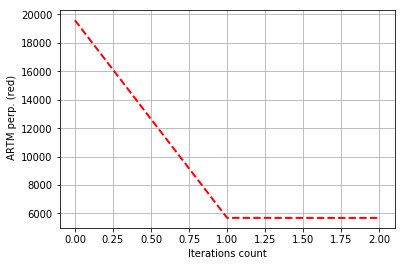

5689.10888671875

In [47]:
# посмотрим, что стало с моделью
# если график сильно падал на последних итерациях, то можно прогнать обучение ещё несколько раз 
# (не добавляя другие регуляризаторы)
print_measures(model_artm)

Добавим регуляризаторы разреженности тем и документов.

Их рекомендуется добавлять после того, как модель уже как-то сошлась. После добавления их рекомендуется постепенно уменьшать, чтобы усиливать разреживание. Их можно применять не ко всем темам, чтобы в каких-то темах собрались все стоп-слова.

Можно добавлять их вместе или по отдельности.

In [48]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]))

In [49]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [50]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.5))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

Sparsity Phi: 0.830 (ARTM)
Sparsity Theta: 0.135 (ARTM)
Kernel contrast: 0.277 (ARTM)
Kernel purity: 0.228 (ARTM)
Perplexity: 2904.250 (ARTM)


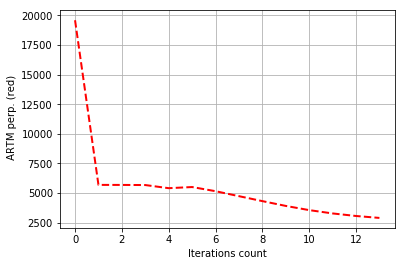

2904.25048828125

In [51]:
# посмотрим на качество
print_measures(model_artm)

Перплексия должна снижаться. Если график выровнился и больше не меняется - модель сошлась. Обычно перплексия хорошей модели около 200-1000. На таком небольшом количестве данных возможно такого значения достичь не получится.

### 5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем;

In [52]:
def grid_search(batch_vectorizer,
         dictionary,
         num_topics=200,
         tau_smooth=0.25,
         tau_sparse=-0.15,
         n_epochs=10,
         n_doc_passes=2,
         sparse_phi=False, 
         sparse_theta=False):
    model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(num_topics)],
                           regularizers=[
                               artm.DecorrelatorPhiRegularizer(
                                   name='Decorr',
                                   tau=tau_smooth,
                                   class_ids=['@default_class'],
                                   topic_names=['topic_{}'.format(i) for i in range(1, num_topics)]),
                               artm.SmoothSparsePhiRegularizer(
                                   name='SmoothPhi_1', 
                                   class_ids=['@default_class'],
                                   tau=tau_smooth, 
                                   topic_names=['topic_{}'.format(i) for i in range(0, num_topics)])])

    model_artm.num_document_passes = n_doc_passes
    model_artm.initialize(dictionary=dictionary, )
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
    model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

    if sparse_phi:
        model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=tau_sparse, 
                                                                topic_names=['topic_{}'.format(i) for i in range(1, num_topics)],
                                                                ))
        phi_tau = model_artm.regularizers['SparsePhi'].tau
    if sparse_theta:
        model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=tau_sparse, 
                                                                  topic_names=['topic_{}'.format(i) for i in range(1, num_topics)]))
        theta_tau = model_artm.regularizers['SparseTheta'].tau
                          
    for i in range(n_epochs):
        model_artm.fit_offline(batch_vectorizer=batch_vectorizer,
                               num_collection_passes=1)
        if sparse_phi:
            model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
        if sparse_theta:
            model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.5))

    perplexity = print_measures(model_artm)
    return perplexity, model_artm

In [53]:
dictionary = artm.Dictionary()
dictionary.load_text('new_eng_dict.txt')

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.046 (ARTM)
Kernel contrast: 0.108 (ARTM)
Kernel purity: 0.031 (ARTM)
Perplexity: 4463.427 (ARTM)


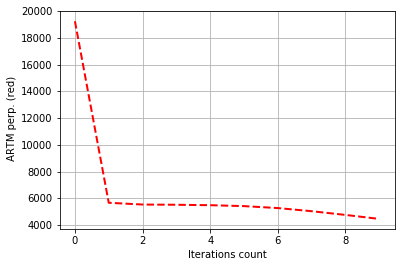

In [54]:
perplexity, model_artm = grid_search(batch_vectorizer=batch_vectorizer,
                  dictionary=dictionary,
                  sparse_phi=True, 
                  sparse_theta=True)

Преплексия очень сильно увеличилась, странно...

Sparsity Phi: 0.161 (ARTM)
Sparsity Theta: 0.142 (ARTM)
Kernel contrast: 0.244 (ARTM)
Kernel purity: 0.412 (ARTM)
Perplexity: 2503.447 (ARTM)


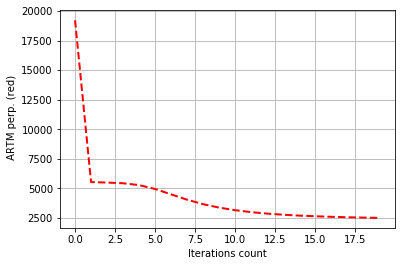

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.223 (ARTM)
Kernel purity: 0.268 (ARTM)
Perplexity: 2928.676 (ARTM)


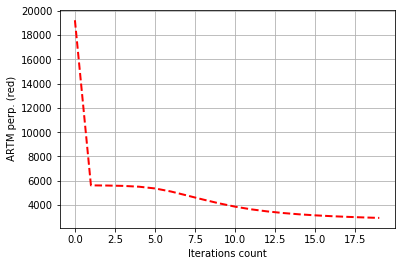

Sparsity Phi: 0.385 (ARTM)
Sparsity Theta: 0.388 (ARTM)
Kernel contrast: 0.229 (ARTM)
Kernel purity: 0.356 (ARTM)
Perplexity: 2259.235 (ARTM)


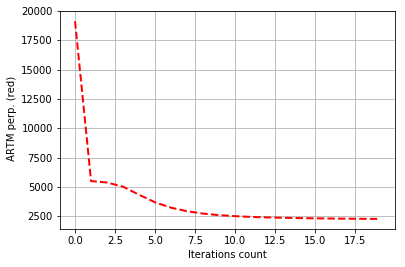

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.219 (ARTM)
Kernel purity: 0.274 (ARTM)
Perplexity: 2520.579 (ARTM)


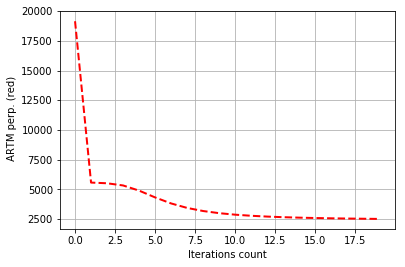

Sparsity Phi: 0.930 (ARTM)
Sparsity Theta: 0.353 (ARTM)
Kernel contrast: 0.408 (ARTM)
Kernel purity: 0.569 (ARTM)
Perplexity: 2801.042 (ARTM)


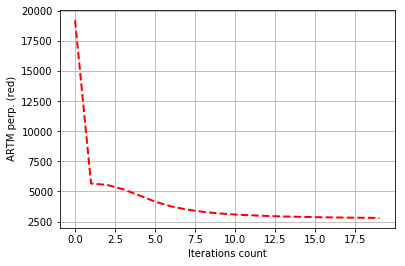

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.223 (ARTM)
Kernel purity: 0.268 (ARTM)
Perplexity: 2928.676 (ARTM)


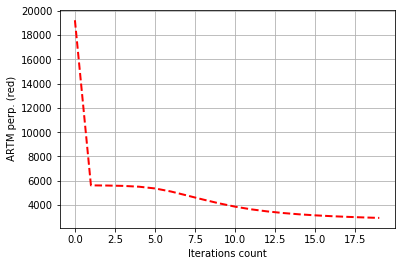

Sparsity Phi: 0.924 (ARTM)
Sparsity Theta: 0.564 (ARTM)
Kernel contrast: 0.356 (ARTM)
Kernel purity: 0.531 (ARTM)
Perplexity: 2636.129 (ARTM)


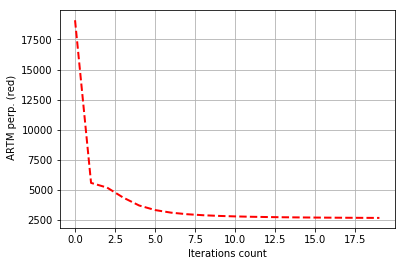

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.219 (ARTM)
Kernel purity: 0.274 (ARTM)
Perplexity: 2520.579 (ARTM)


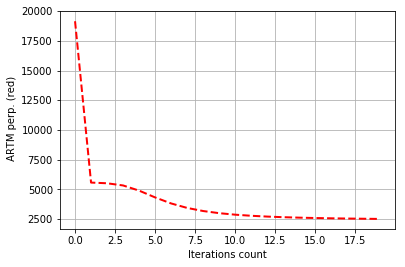

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.050 (ARTM)
Kernel contrast: 0.183 (ARTM)
Kernel purity: 0.185 (ARTM)
Perplexity: 3323.848 (ARTM)


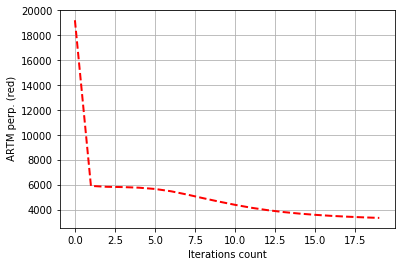

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.147 (ARTM)
Kernel purity: 0.143 (ARTM)
Perplexity: 3717.135 (ARTM)


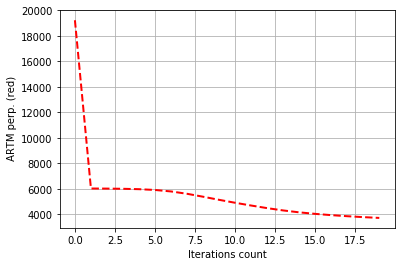

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.423 (ARTM)
Kernel contrast: 0.188 (ARTM)
Kernel purity: 0.199 (ARTM)
Perplexity: 2829.274 (ARTM)


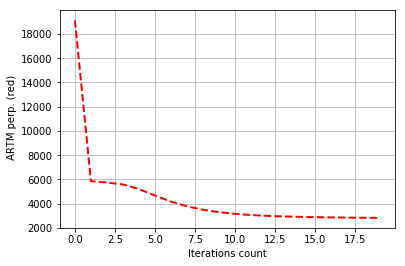

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.154 (ARTM)
Kernel purity: 0.168 (ARTM)
Perplexity: 3092.362 (ARTM)


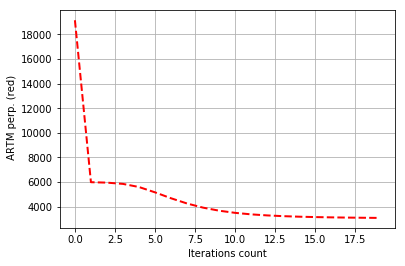

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.311 (ARTM)
Kernel contrast: 0.231 (ARTM)
Kernel purity: 0.356 (ARTM)
Perplexity: 2540.324 (ARTM)


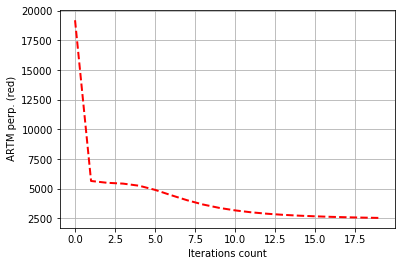

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.147 (ARTM)
Kernel purity: 0.143 (ARTM)
Perplexity: 3717.135 (ARTM)


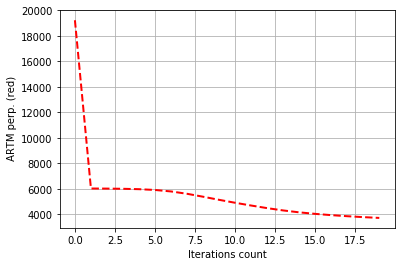

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.598 (ARTM)
Kernel contrast: 0.217 (ARTM)
Kernel purity: 0.299 (ARTM)
Perplexity: 2298.474 (ARTM)


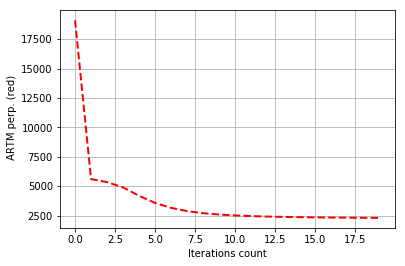

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.154 (ARTM)
Kernel purity: 0.168 (ARTM)
Perplexity: 3092.362 (ARTM)


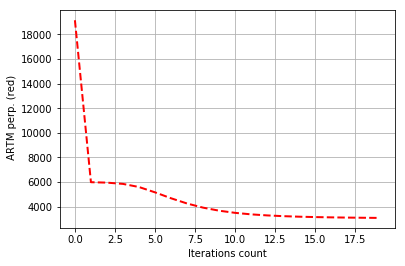

Sparsity Phi: 0.245 (ARTM)
Sparsity Theta: 0.299 (ARTM)
Kernel contrast: 0.231 (ARTM)
Kernel purity: 0.342 (ARTM)
Perplexity: 2039.108 (ARTM)


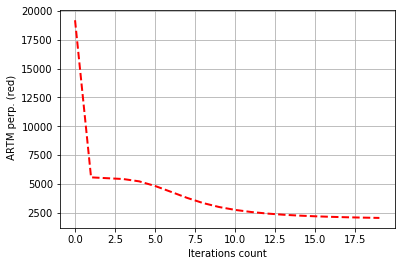

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.149 (ARTM)
Kernel purity: 0.152 (ARTM)
Perplexity: 2955.663 (ARTM)


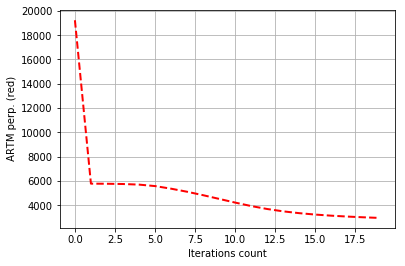

Sparsity Phi: 0.555 (ARTM)
Sparsity Theta: 0.591 (ARTM)
Kernel contrast: 0.212 (ARTM)
Kernel purity: 0.263 (ARTM)
Perplexity: 1803.747 (ARTM)


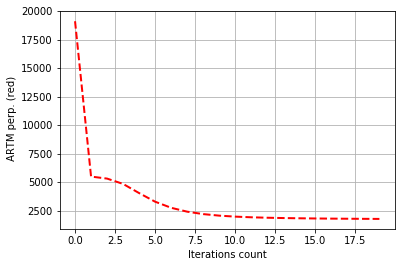

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.180 (ARTM)
Kernel purity: 0.167 (ARTM)
Perplexity: 2355.041 (ARTM)


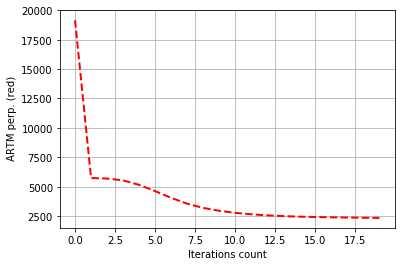

Sparsity Phi: 0.969 (ARTM)
Sparsity Theta: 0.576 (ARTM)
Kernel contrast: 0.464 (ARTM)
Kernel purity: 0.541 (ARTM)
Perplexity: 2545.967 (ARTM)


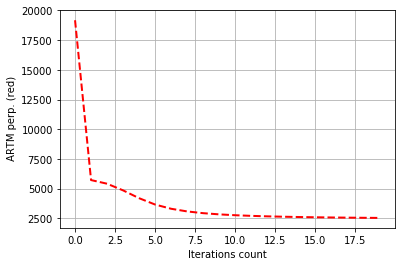

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.149 (ARTM)
Kernel purity: 0.152 (ARTM)
Perplexity: 2955.663 (ARTM)


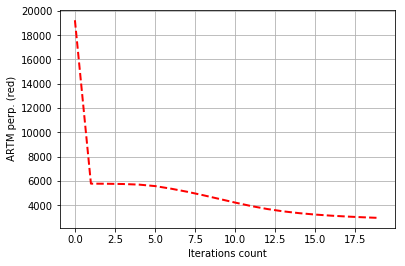

Sparsity Phi: 0.965 (ARTM)
Sparsity Theta: 0.719 (ARTM)
Kernel contrast: 0.411 (ARTM)
Kernel purity: 0.501 (ARTM)
Perplexity: 2410.223 (ARTM)


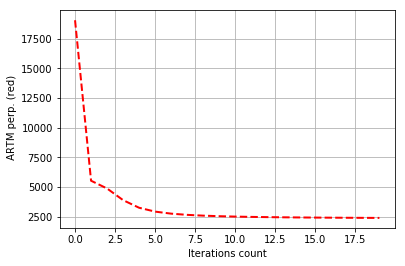

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.180 (ARTM)
Kernel purity: 0.167 (ARTM)
Perplexity: 2355.041 (ARTM)


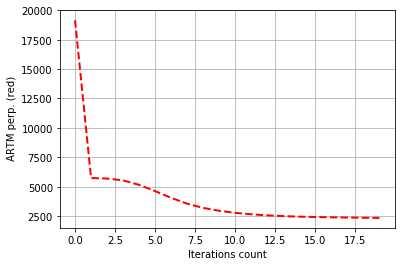

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.193 (ARTM)
Kernel contrast: 0.072 (ARTM)
Kernel purity: 0.090 (ARTM)
Perplexity: 3370.298 (ARTM)


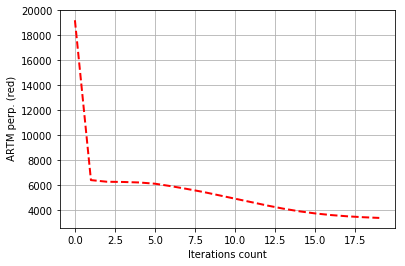

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.046 (ARTM)
Kernel purity: 0.059 (ARTM)
Perplexity: 3939.457 (ARTM)


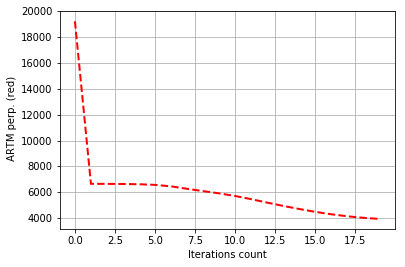

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.735 (ARTM)
Kernel contrast: 0.096 (ARTM)
Kernel purity: 0.103 (ARTM)
Perplexity: 2815.251 (ARTM)


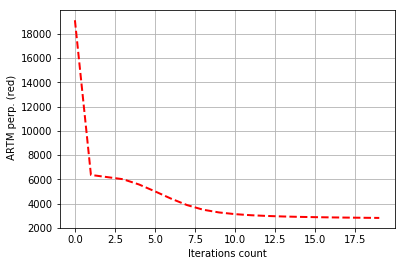

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.057 (ARTM)
Kernel purity: 0.076 (ARTM)
Perplexity: 3200.972 (ARTM)


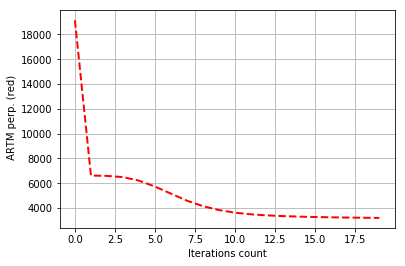

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.531 (ARTM)
Kernel contrast: 0.232 (ARTM)
Kernel purity: 0.279 (ARTM)
Perplexity: 2129.992 (ARTM)


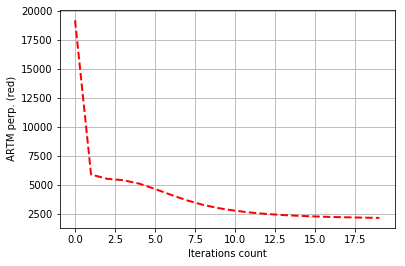

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.046 (ARTM)
Kernel purity: 0.059 (ARTM)
Perplexity: 3939.456 (ARTM)


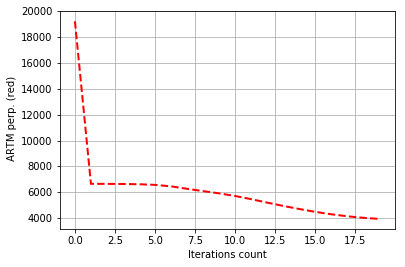

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.782 (ARTM)
Kernel contrast: 0.208 (ARTM)
Kernel purity: 0.201 (ARTM)
Perplexity: 1873.778 (ARTM)


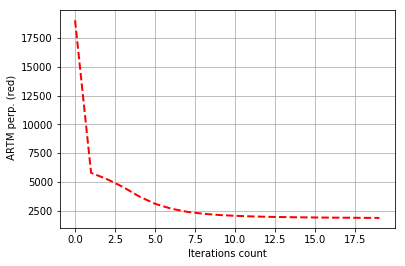

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.057 (ARTM)
Kernel purity: 0.076 (ARTM)
Perplexity: 3200.971 (ARTM)


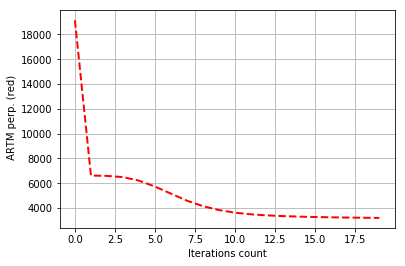

Sparsity Phi: 0.316 (ARTM)
Sparsity Theta: 0.427 (ARTM)
Kernel contrast: 0.229 (ARTM)
Kernel purity: 0.323 (ARTM)
Perplexity: 1768.041 (ARTM)


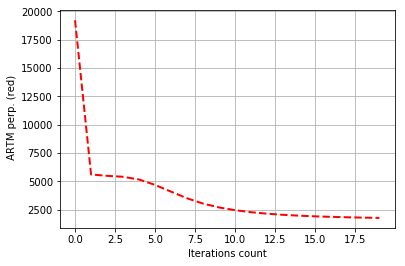

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.092 (ARTM)
Kernel purity: 0.100 (ARTM)
Perplexity: 3051.863 (ARTM)


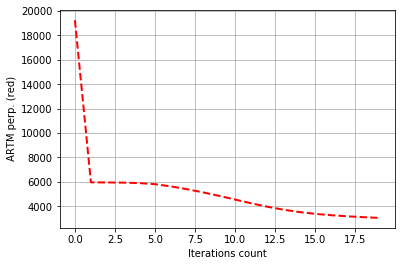

Sparsity Phi: 0.661 (ARTM)
Sparsity Theta: 0.717 (ARTM)
Kernel contrast: 0.209 (ARTM)
Kernel purity: 0.229 (ARTM)
Perplexity: 1522.667 (ARTM)


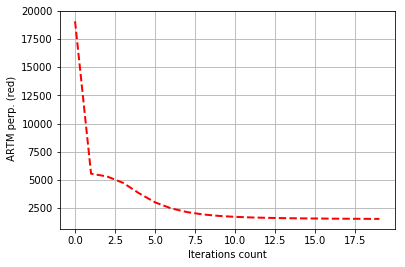

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.116 (ARTM)
Kernel purity: 0.115 (ARTM)
Perplexity: 2346.502 (ARTM)


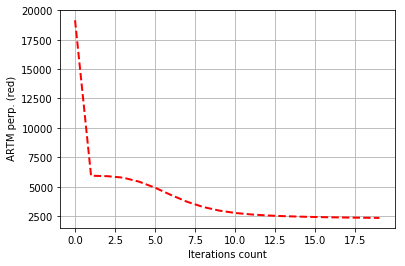

Sparsity Phi: 0.981 (ARTM)
Sparsity Theta: 0.694 (ARTM)
Kernel contrast: 0.556 (ARTM)
Kernel purity: 0.563 (ARTM)
Perplexity: 2383.846 (ARTM)


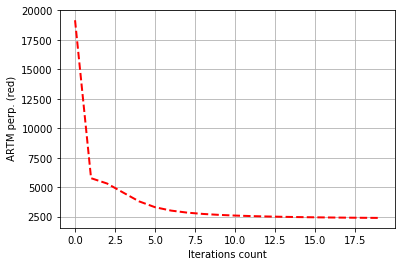

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.092 (ARTM)
Kernel purity: 0.100 (ARTM)
Perplexity: 3051.863 (ARTM)


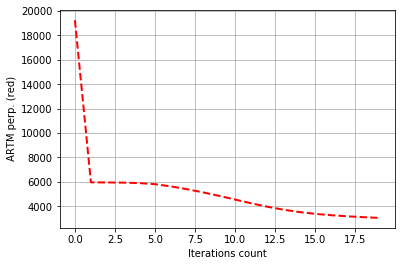

Sparsity Phi: 0.978 (ARTM)
Sparsity Theta: 0.781 (ARTM)
Kernel contrast: 0.479 (ARTM)
Kernel purity: 0.514 (ARTM)
Perplexity: 2263.456 (ARTM)


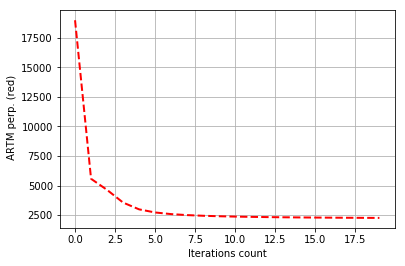

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.116 (ARTM)
Kernel purity: 0.115 (ARTM)
Perplexity: 2346.502 (ARTM)


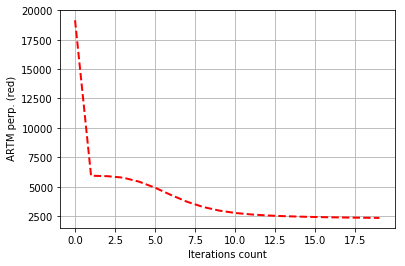

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.356 (ARTM)
Kernel contrast: 0.046 (ARTM)
Kernel purity: 0.059 (ARTM)
Perplexity: 3400.017 (ARTM)


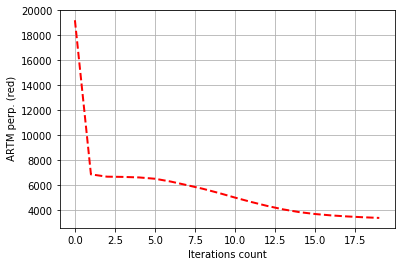

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.025 (ARTM)
Kernel purity: 0.036 (ARTM)
Perplexity: 4077.820 (ARTM)


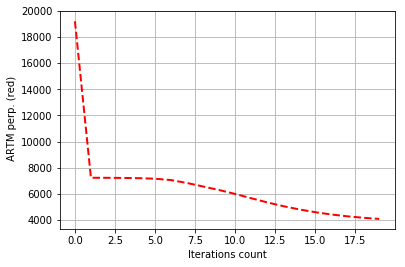

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.845 (ARTM)
Kernel contrast: 0.060 (ARTM)
Kernel purity: 0.070 (ARTM)
Perplexity: 2829.863 (ARTM)


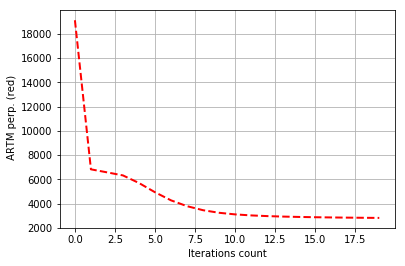

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.034 (ARTM)
Kernel purity: 0.050 (ARTM)
Perplexity: 3278.808 (ARTM)


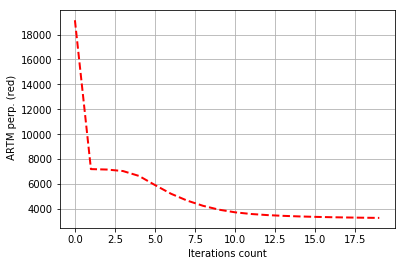

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.671 (ARTM)
Kernel contrast: 0.234 (ARTM)
Kernel purity: 0.240 (ARTM)
Perplexity: 1881.227 (ARTM)


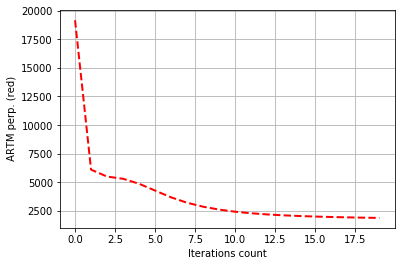

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.025 (ARTM)
Kernel purity: 0.036 (ARTM)
Perplexity: 4077.819 (ARTM)


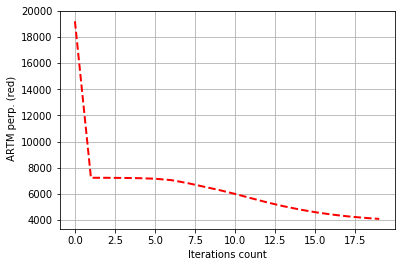

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.864 (ARTM)
Kernel contrast: 0.203 (ARTM)
Kernel purity: 0.152 (ARTM)
Perplexity: 1651.213 (ARTM)


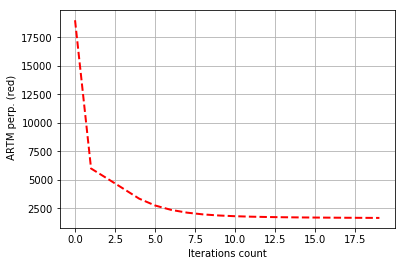

Sparsity Phi: 0.000 (ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.034 (ARTM)
Kernel purity: 0.050 (ARTM)
Perplexity: 3278.808 (ARTM)


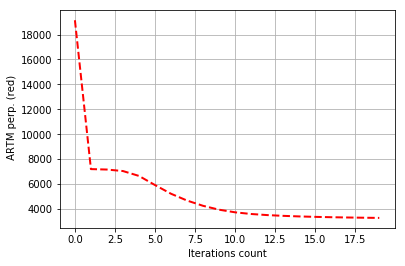

In [84]:
num_topics = [100, 200, 300]
tau_smooth = [0.15, 0.5]
num_passes = [3, 5]
tau_sparse = [-0.1, -0.3]

res = []
for t in num_topics:
    for tau_sm in tau_smooth:
        for tau_sp in tau_sparse:
            for p in num_passes:
                for sp in [True, False]:
                    perplexity, model_artm = grid_search(batch_vectorizer=batch_vectorizer,
                                                  dictionary=dictionary,
                                                  num_topics=t,
                                                  tau_smooth=tau_sm,
                                                  tau_sparse=tau_sp,
                                                  n_epochs=20,
                                                  n_doc_passes=p,
                                                  sparse_phi=sp, 
                                                  sparse_theta=sp)
                    res.append([t, tau_sm, tau_sp, p, sp, perplexity])

### 6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

In [57]:
from copy import copy

In [58]:
res[:3]

[[100, 1.0, True, 3, True, 6017.25830078125],
 [100, 1.0, False, 3, False, 4229.27197265625],
 [100, 1.0, True, 5, True, 5246.140625]]

In [86]:
top_1 = [100, 1.0, True, 3, True, 66017.25830078125]
top_1

[100, 1.0, True, 3, True, 66017.25830078125]

In [87]:
top_2 = [100, 1.0, True, 3, True, 66017.25830078125]
top_2

[100, 1.0, True, 3, True, 66017.25830078125]

In [88]:
top_3 = [100, 1.0, True, 3, True, 66017.25830078125]
top_3

[100, 1.0, True, 3, True, 66017.25830078125]

In [89]:

for result in res:
    
    if result[5] <= top_1[5]:
        top_3 = copy(top_2)
        top_2 = copy(top_1)
        top_1 = copy(result)
        continue
    
    if result[5] <= top_2[5]:
        top_3 = copy(top_2)
        top_2 = copy(result)
        continue
    
    if result[5] <= top_3[5]:
        top_3 = copy(result)

In [90]:
print(top_1, top_2, top_3)

[300, 0.15, -0.1, 5, True, 1522.66650390625] [300, 0.5, -0.3, 5, True, 1651.212646484375] [300, 0.15, -0.1, 3, True, 1768.0411376953125]


Sparsity Phi: 0.661 (ARTM)
Sparsity Theta: 0.717 (ARTM)
Kernel contrast: 0.209 (ARTM)
Kernel purity: 0.229 (ARTM)
Perplexity: 1522.667 (ARTM)


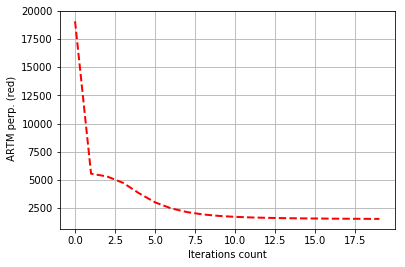

In [91]:
perplexity, model_artm = grid_search(batch_vectorizer=batch_vectorizer,
                              dictionary=dictionary,
                              num_topics=top_1[0],
                              tau_smooth=top_1[1],
                              tau_sparse=top_1[2],
                              n_epochs=20,
                              n_doc_passes=top_1[3],
                              sparse_phi=top_1[4], 
                              sparse_theta=top_1[4])

In [92]:
# посмотрим на темы
for topic_name in model_artm.topic_names[:20]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
        continue

topic_0: 
мероприятие
встреча
тема
пройти
состояться
рассказать
приглашать
митапа
посвятить
москва
---------
topic_1: 
ноутбук
устройство
компьютер
рубль
доллар
процессор
стоить
lenovo
экран
клавиатура
---------
topic_2: 
ридер
модель
экран
подсветка
именно
компания
устройство
обложка
формат
книга
---------
topic_3: 
открытый
являться
яндекс
конкурс
результат
свободный
портал
авторский_право
решение
цифровой
---------
topic_4: 
чип
процессор
частица
закон_мура
позволять
поль
система
новое
область
образец
---------
topic_5: 
аккумулятор
батарея
ёмкость
микросхема
процессор
электрод
зарядка
компания
производство
электроника
---------
topic_6: 
иконка
программный_продукт
решение
сайт
создание
компания
значок
приложение
продукт
платформа
---------
topic_7: 
заказчик
команда
задача
исполнитель
разработка
процесс
требование
результат
отдел
срок
---------
topic_8: 
тз
просить
хотеть
понять
почему
проект
мысль
фраза
команда
скорее
---------
topic_9: 
плата
линия
usb
arduino
тестовый
устройство

- ЭЛЕКТРОНИКА
    topic_5: 
    * аккумулятор
    * батарея
    * ёмкость
    * микросхема
    * процессор
    * электрод
    * зарядка
    * компания
    * производство
    * электроника



- КОМПЬЮТЕРНАЯ БЕЗОПАСНОСТЬ

    topic_12: 
    * злоумышленник
    * инцидент
    * компания
    * утечка
    * жертва
    * информация
    * вредоносный
    * вредоносный_программа
    * утечка_дать
    * случай
    
    
- КОНКУРС ЯНДЕКС

    topic_3: 
    * открытый
    * являться
    * яндекс
    * конкурс
    * результат
    * свободный
    * портал
    * авторский_право
    * решение
    * цифровой

### 7) в другой ячейке нарисуйте график обучения этой модели

Sparsity Phi: 0.661 (ARTM)
Sparsity Theta: 0.717 (ARTM)
Kernel contrast: 0.209 (ARTM)
Kernel purity: 0.229 (ARTM)
Perplexity: 1522.667 (ARTM)


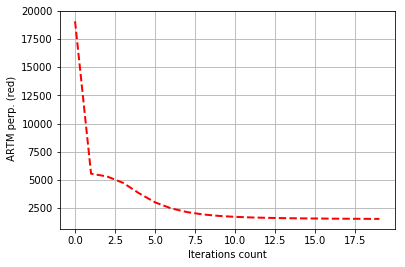

In [93]:
perplexity = print_measures(model_artm)

### 8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

Я сразу решила перебирать набор параметров и просто найти лучшее сочетание.


Лучше всего вышло при:
    - num_topics 300
    - tau_smooth = 0.15
    - num_passes = 5
    - tau_sparse = -0.1
    - phi и theta = True

Модель сошлась где-то на 12.5 итерации.